# NeMo RL Training Log Analysis
## Analyze and visualize training metrics from TensorBoard and W&B logs

This notebook allows you to:
- Load and analyze TensorBoard event files
- Parse W&B offline logs
- Plot training loss, learning rate, and other metrics
- Compare multiple experiments
- Generate training reports

In [1]:
# Install required packages if not already available
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import tensorboard
except ImportError:
    install_package("tensorboard")
    
try:
    import wandb
except ImportError:
    install_package("wandb")

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [6]:
# Import required libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# TensorBoard related imports
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import tensorflow as tf

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("📊 Libraries imported successfully!")

2025-08-07 09:54:35.645515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 09:54:35.803574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754560475.868202 2938903 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754560475.886074 2938903 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754560475.999731 2938903 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

📊 Libraries imported successfully!


In [7]:
# Configuration
LOG_BASE_DIR = "/mnt/nunomg/nemo-rl/logs"

# You can change this to analyze a specific experiment
EXPERIMENT_PATH = "/mnt/nunomg/nemo-rl/logs/sft-openmathinstruct2/exp_002"

print(f"📁 Base log directory: {LOG_BASE_DIR}")
print(f"🔍 Analyzing experiment: {EXPERIMENT_PATH}")

📁 Base log directory: /mnt/nunomg/nemo-rl/logs
🔍 Analyzing experiment: /mnt/nunomg/nemo-rl/logs/sft-openmathinstruct2/exp_002


In [8]:
def load_tensorboard_data(log_dir):
    """
    Load data from TensorBoard event files
    """
    tb_dir = os.path.join(log_dir, 'tensorboard')
    if not os.path.exists(tb_dir):
        print(f"❌ No TensorBoard directory found at {tb_dir}")
        return None
    
    # Find event files
    event_files = glob.glob(os.path.join(tb_dir, '**/*.tfevents.*'), recursive=True)
    if not event_files:
        print(f"❌ No TensorBoard event files found in {tb_dir}")
        return None
    
    print(f"📊 Found {len(event_files)} TensorBoard event files")
    
    # Load data from all event files
    all_data = defaultdict(list)
    
    for event_file in event_files:
        print(f"📖 Loading: {os.path.basename(event_file)}")
        
        try:
            ea = EventAccumulator(event_file)
            ea.Reload()
            
            # Get available scalar tags
            scalar_tags = ea.Tags()['scalars']
            print(f"   Available metrics: {scalar_tags}")
            
            # Extract scalar data
            for tag in scalar_tags:
                scalar_events = ea.Scalars(tag)
                for event in scalar_events:
                    all_data['step'].append(event.step)
                    all_data['wall_time'].append(event.wall_time)
                    all_data['metric'].append(tag)
                    all_data['value'].append(event.value)
                    all_data['source_file'].append(os.path.basename(event_file))
        
        except Exception as e:
            print(f"⚠️ Error loading {event_file}: {e}")
            continue
    
    if not all_data:
        print("❌ No data loaded from TensorBoard files")
        return None
    
    df = pd.DataFrame(all_data)
    df['timestamp'] = pd.to_datetime(df['wall_time'], unit='s')
    
    print(f"✅ Loaded {len(df)} data points from TensorBoard")
    print(f"📈 Metrics available: {df['metric'].unique().tolist()}")
    
    return df

# Load TensorBoard data
tb_data = load_tensorboard_data(EXPERIMENT_PATH)
if tb_data is not None:
    print(f"\n📊 TensorBoard data shape: {tb_data.shape}")
    print(tb_data.head())

# I want to estimate the average step time for training
def estimate_average_step_time(tb_data):
    """
    Estimate the average step time from TensorBoard data
    """
    if tb_data is None or tb_data.empty:
        print("❌ No TensorBoard data available for step time estimation")
        return None
    
    # Filter for training loss metric
    train_loss_data = tb_data[tb_data['metric'] == 'train/loss']
    
    if train_loss_data.empty:
        print("❌ No training loss data found")
        return None
    
    # Calculate time differences between last 10% steps
    train_loss_data = train_loss_data.sort_values(by='step')
    train_loss_data = train_loss_data.tail(int(len(train_loss_data) * 0.1))
    train_loss_data['time_diff'] = train_loss_data['timestamp'].diff().dt.total_seconds()
    
    # Calculate average step time
    avg_step_time = train_loss_data['time_diff'].mean()
    
    print(f"⏱️ Average step time: {avg_step_time:.2f} seconds")
    
    return avg_step_time

# Estimate average step time
avg_step_time = estimate_average_step_time(tb_data)


📊 Found 2 TensorBoard event files
📖 Loading: events.out.tfevents.1754519783.computeinstance-e00rytbbesq4p7eszj.1262.0
   Available metrics: ['ray/node.0.gpu.0.util', 'ray/node.0.gpu.1.util', 'ray/node.0.gpu.2.util', 'ray/node.0.gpu.3.util', 'ray/node.0.gpu.4.util', 'ray/node.0.gpu.5.util', 'ray/node.0.gpu.6.util', 'ray/node.0.gpu.7.util', 'ray/node.0.gpu.0.mem_gb', 'ray/node.0.gpu.1.mem_gb', 'ray/node.0.gpu.2.mem_gb', 'ray/node.0.gpu.3.mem_gb', 'ray/node.0.gpu.4.mem_gb', 'ray/node.0.gpu.5.mem_gb', 'ray/node.0.gpu.6.mem_gb', 'ray/node.0.gpu.7.mem_gb', 'ray/node.0.mem_gb', 'ray/node.0.mem_total_gb', 'ray/node.1.gpu.0.util', 'ray/node.1.gpu.1.util', 'ray/node.1.gpu.2.util', 'ray/node.1.gpu.3.util', 'ray/node.1.gpu.4.util', 'ray/node.1.gpu.5.util', 'ray/node.1.gpu.6.util', 'ray/node.1.gpu.7.util', 'ray/node.1.gpu.0.mem_gb', 'ray/node.1.gpu.1.mem_gb', 'ray/node.1.gpu.2.mem_gb', 'ray/node.1.gpu.3.mem_gb', 'ray/node.1.gpu.4.mem_gb', 'ray/node.1.gpu.5.mem_gb', 'ray/node.1.gpu.6.mem_gb', 'ray/n

In [9]:
# Print the learning rate 
def print_learning_rate(tb_data):
    """
    Print the learning rate from TensorBoard data
    """
    if tb_data is None or tb_data.empty:
        print("❌ No TensorBoard data available for learning rate")
        return
    
    # Filter for learning rate metric
    lr_data = tb_data[tb_data['metric'] == 'train/lr']
    
    if lr_data.empty:
        print("❌ No learning rate data found")
        return
    
    # Get the latest learning rate value
    latest_lr = lr_data['value'].iloc[-1]
    
    print(f"📈 Latest learning rate: {latest_lr:.7f}")

print_learning_rate(tb_data)

📈 Latest learning rate: 0.0000007


📊 Plotting 48 metrics: ['ray/node.0.gpu.0.util', 'ray/node.0.gpu.1.util', 'ray/node.0.gpu.2.util', 'ray/node.0.gpu.3.util', 'ray/node.0.gpu.4.util', 'ray/node.0.gpu.5.util', 'ray/node.0.gpu.6.util', 'ray/node.0.gpu.7.util', 'ray/node.0.gpu.0.mem_gb', 'ray/node.0.gpu.1.mem_gb', 'ray/node.0.gpu.2.mem_gb', 'ray/node.0.gpu.3.mem_gb', 'ray/node.0.gpu.4.mem_gb', 'ray/node.0.gpu.5.mem_gb', 'ray/node.0.gpu.6.mem_gb', 'ray/node.0.gpu.7.mem_gb', 'ray/node.0.mem_gb', 'ray/node.0.mem_total_gb', 'ray/node.1.gpu.0.util', 'ray/node.1.gpu.1.util', 'ray/node.1.gpu.2.util', 'ray/node.1.gpu.3.util', 'ray/node.1.gpu.4.util', 'ray/node.1.gpu.5.util', 'ray/node.1.gpu.6.util', 'ray/node.1.gpu.7.util', 'ray/node.1.gpu.0.mem_gb', 'ray/node.1.gpu.1.mem_gb', 'ray/node.1.gpu.2.mem_gb', 'ray/node.1.gpu.3.mem_gb', 'ray/node.1.gpu.4.mem_gb', 'ray/node.1.gpu.5.mem_gb', 'ray/node.1.gpu.6.mem_gb', 'ray/node.1.gpu.7.mem_gb', 'ray/node.1.mem_gb', 'ray/node.1.mem_total_gb', 'ray/ray/ray_step', 'train/loss', 'train/grad_no

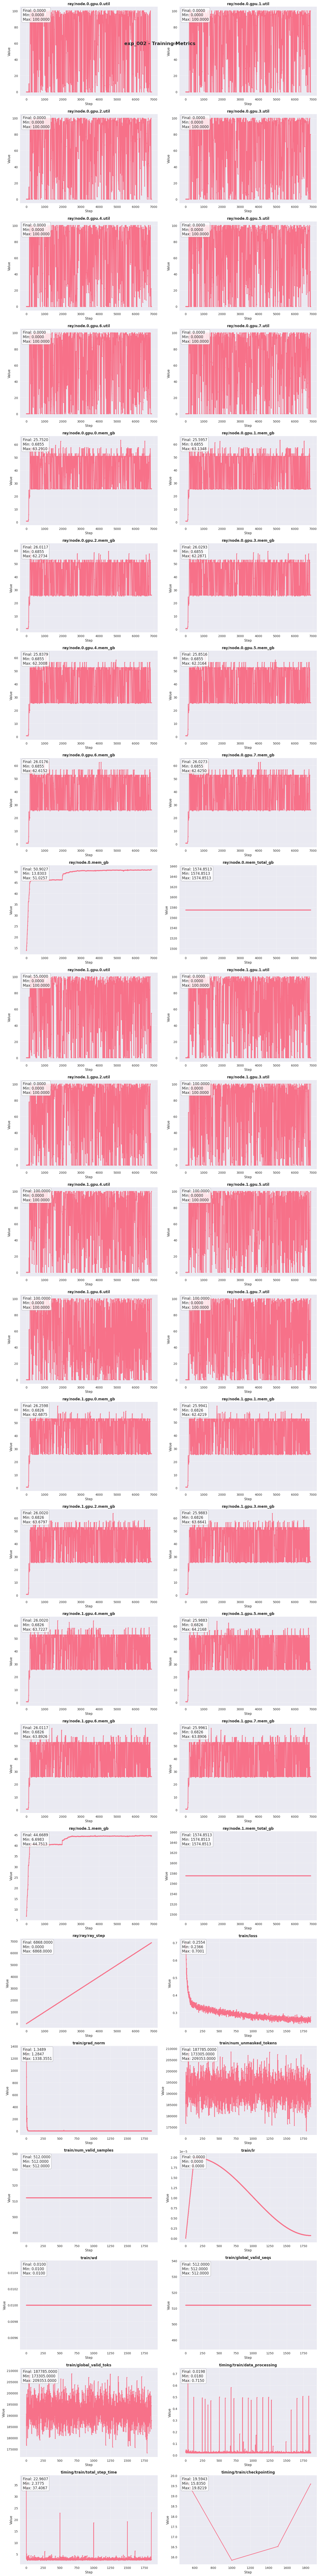

In [10]:
def plot_training_metrics(data, experiment_name="Training Run"):
    """
    Plot training metrics from the loaded data
    """
    if data is None or data.empty:
        print("❌ No data to plot")
        return
    
    # Get unique metrics
    metrics = data['metric'].unique()
    print(f"📊 Plotting {len(metrics)} metrics: {metrics.tolist()}")
    
    # Create subplots based on number of metrics
    n_metrics = len(metrics)
    n_cols = min(2, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_metrics == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten() if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle(f'{experiment_name} - Training Metrics', fontsize=16, fontweight='bold')
    
    for i, metric in enumerate(metrics):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Filter data for this metric
        metric_data = data[data['metric'] == metric].copy()
        metric_data = metric_data.sort_values('step')
        
        # Plot the metric
        ax.plot(metric_data['step'], metric_data['value'], linewidth=2, marker='o', markersize=3)
        ax.set_title(f'{metric}', fontweight='bold')
        ax.set_xlabel('Step')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        # Add some statistics
        final_value = metric_data['value'].iloc[-1] if not metric_data.empty else 0
        min_value = metric_data['value'].min() if not metric_data.empty else 0
        max_value = metric_data['value'].max() if not metric_data.empty else 0
        
        stats_text = f'Final: {final_value:.4f}\nMin: {min_value:.4f}\nMax: {max_value:.4f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide unused subplots
    for i in range(len(metrics), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Plot the metrics if we have TensorBoard data
if tb_data is not None:
    exp_name = os.path.basename(EXPERIMENT_PATH)
    plot_training_metrics(tb_data, exp_name)
else:
    print("📊 No TensorBoard data available to plot")

In [ ]:
def compare_experiments(base_dir, experiment_patterns=["**/exp_*"]):
    """
    Compare multiple experiments
    """
    experiments = []
    
    for pattern in experiment_patterns:
        exp_dirs = glob.glob(os.path.join(base_dir, pattern), recursive=True)
        experiments.extend([d for d in exp_dirs if os.path.isdir(d)])
    
    if not experiments:
        print(f"❌ No experiments found matching patterns: {experiment_patterns}")
        return
    
    print(f"🔍 Found {len(experiments)} experiments to compare")
    
    # Load data from all experiments
    all_exp_data = {}
    for exp_dir in experiments[:5]:  # Limit to 5 experiments for readability
        exp_name = os.path.relpath(exp_dir, base_dir)
        print(f"📖 Loading {exp_name}...")
        
        exp_data = load_tensorboard_data(exp_dir)
        if exp_data is not None:
            all_exp_data[exp_name] = exp_data
    
    if not all_exp_data:
        print("❌ No experiment data loaded")
        return
    
    # Find common metrics across experiments
    common_metrics = None
    for exp_name, exp_data in all_exp_data.items():
        exp_metrics = set(exp_data['metric'].unique())
        if common_metrics is None:
            common_metrics = exp_metrics
        else:
            common_metrics = common_metrics.intersection(exp_metrics)
    
    if not common_metrics:
        print("❌ No common metrics found across experiments")
        return
    
    print(f"📊 Comparing {len(common_metrics)} common metrics: {list(common_metrics)}")
    
    # Plot comparison
    n_metrics = len(common_metrics)
    n_cols = min(2, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_metrics == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten() if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Experiment Comparison', fontsize=16, fontweight='bold')
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_exp_data)))
    
    for i, metric in enumerate(common_metrics):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        for j, (exp_name, exp_data) in enumerate(all_exp_data.items()):
            metric_data = exp_data[exp_data['metric'] == metric].copy()
            metric_data = metric_data.sort_values('step')
            
            ax.plot(metric_data['step'], metric_data['value'], 
                   linewidth=2, label=exp_name, color=colors[j], alpha=0.8)
        
        ax.set_title(f'{metric}', fontweight='bold')
        ax.set_xlabel('Step')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Hide unused subplots
    for i in range(len(common_metrics), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Compare experiments (uncomment to run)
# compare_experiments(LOG_BASE_DIR, ["sft-eurollm-9b-2n8g-megatron/exp_*"])

In [ ]:
def generate_training_report(data, experiment_path):
    """
    Generate a comprehensive training report
    """
    if data is None or data.empty:
        print("❌ No data available for report")
        return
    
    print("\n" + "="*60)
    print(f"📊 TRAINING REPORT: {os.path.basename(experiment_path)}")
    print("="*60)
    
    # Basic info
    total_steps = data['step'].max()
    total_metrics = data['metric'].nunique()
    start_time = data['timestamp'].min()
    end_time = data['timestamp'].max()
    duration = end_time - start_time
    
    print(f"🕒 Training Duration: {duration}")
    print(f"📈 Total Steps: {total_steps:,}")
    print(f"📊 Metrics Tracked: {total_metrics}")
    print(f"🚀 Start Time: {start_time}")
    print(f"🏁 End Time: {end_time}")
    
    print("\n📈 METRIC SUMMARY:")
    print("-" * 40)
    
    # Metric summary
    for metric in sorted(data['metric'].unique()):
        metric_data = data[data['metric'] == metric]
        
        initial_value = metric_data.loc[metric_data['step'].idxmin(), 'value']
        final_value = metric_data.loc[metric_data['step'].idxmax(), 'value']
        min_value = metric_data['value'].min()
        max_value = metric_data['value'].max()
        mean_value = metric_data['value'].mean()
        std_value = metric_data['value'].std()
        
        change = final_value - initial_value
        change_pct = (change / initial_value * 100) if initial_value != 0 else 0
        
        print(f"\n🔹 {metric}:")
        print(f"   Initial: {initial_value:.6f}")
        print(f"   Final:   {final_value:.6f} ({change:+.6f}, {change_pct:+.2f}%)")
        print(f"   Range:   [{min_value:.6f}, {max_value:.6f}]")
        print(f"   Mean±Std: {mean_value:.6f} ± {std_value:.6f}")
    
    # Training efficiency metrics
    if total_steps > 0 and duration.total_seconds() > 0:
        steps_per_second = total_steps / duration.total_seconds()
        print(f"\n⚡ TRAINING EFFICIENCY:")
        print("-" * 40)
        print(f"Steps per second: {steps_per_second:.3f}")
        print(f"Steps per minute: {steps_per_second * 60:.1f}")
        print(f"Steps per hour: {steps_per_second * 3600:.0f}")
    
    print("\n" + "="*60)

# Generate report if we have data
if tb_data is not None:
    generate_training_report(tb_data, EXPERIMENT_PATH)

In [ ]:
# Interactive experiment selector
def list_all_experiments(base_dir):
    """
    List all available experiments
    """
    experiments = []
    
    for root, dirs, files in os.walk(base_dir):
        if 'tensorboard' in dirs:
            rel_path = os.path.relpath(root, base_dir)
            if rel_path != '.':
                experiments.append(os.path.join(base_dir, rel_path))
    
    return sorted(experiments)

# List all experiments
all_experiments = list_all_experiments(LOG_BASE_DIR)
print("🔍 All available experiments:")
for i, exp in enumerate(all_experiments):
    rel_path = os.path.relpath(exp, LOG_BASE_DIR)
    print(f"  {i+1:2d}. {rel_path}")

print(f"\n💡 To analyze a different experiment, change the EXPERIMENT_PATH variable in cell 3")
print(f"   Current: {os.path.relpath(EXPERIMENT_PATH, LOG_BASE_DIR)}")

In [ ]:
# Quick experiment switcher - Change the experiment number here!
EXPERIMENT_NUMBER = 1  # Change this to analyze a different experiment

if 1 <= EXPERIMENT_NUMBER <= len(all_experiments):
    EXPERIMENT_PATH = all_experiments[EXPERIMENT_NUMBER - 1]
    print(f"🔄 Switched to experiment: {os.path.relpath(EXPERIMENT_PATH, LOG_BASE_DIR)}")
    
    # Reload and plot data
    tb_data = load_tensorboard_data(EXPERIMENT_PATH)
    if tb_data is not None:
        exp_name = os.path.relpath(EXPERIMENT_PATH, LOG_BASE_DIR)
        plot_training_metrics(tb_data, exp_name)
        generate_training_report(tb_data, EXPERIMENT_PATH)
    else:
        print("❌ No data available for this experiment")
else:
    print(f"❌ Invalid experiment number. Choose between 1 and {len(all_experiments)}")

In [ ]:
# Export data to CSV for further analysis
def export_data_to_csv(data, experiment_path, output_dir="/mnt/nunomg/nemo-rl"):
    """
    Export training data to CSV file
    """
    if data is None or data.empty:
        print("❌ No data to export")
        return
    
    exp_name = os.path.basename(experiment_path).replace('/', '_')
    csv_filename = f"training_data_{exp_name}.csv"
    csv_path = os.path.join(output_dir, csv_filename)
    
    # Prepare data for export
    export_data = data.copy()
    export_data['experiment'] = exp_name
    
    # Save to CSV
    export_data.to_csv(csv_path, index=False)
    print(f"💾 Data exported to: {csv_path}")
    print(f"📊 Exported {len(export_data)} rows with columns: {list(export_data.columns)}")
    
    return csv_path

# Export current experiment data
if tb_data is not None:
    csv_path = export_data_to_csv(tb_data, EXPERIMENT_PATH)
else:
    print("❌ No data available to export")

## 🎯 Usage Instructions

### To analyze a specific experiment:
1. **Change the `EXPERIMENT_PATH`** in the configuration cell (cell 3)
2. **Or use the quick switcher** by changing `EXPERIMENT_NUMBER` in the second-to-last cell

### To compare multiple experiments:
1. **Uncomment the comparison cell** and modify the pattern to match your experiments
2. Example: `compare_experiments(LOG_BASE_DIR, ["sft-eurollm-9b-*/exp_*"])`

### Available features:
- 📊 **Automatic metric plotting** with statistics
- 📈 **Multi-experiment comparison**
- 📋 **Comprehensive training reports**
- 💾 **CSV data export** for further analysis
- 🔍 **Interactive experiment browser**

### Supported log formats:
- ✅ **TensorBoard** event files (`.tfevents.*`)
- ⚠️ **W&B offline logs** (basic support, binary format requires special handling)

---

**Example paths to analyze:**
- `/mnt/nunomg/nemo-rl/logs/sft-eurollm-9b-2n8g-megatron/exp_003`
- `/mnt/nunomg/nemo-rl/logs/sft-eurollm-9b-1n8g-megatron/exp_020`
- `/mnt/nunomg/nemo-rl/logs/exp_025`
